## Heatmap with change-cell-size feature

### Motivation
Heatmap is a great chart to catch information in matrix.  
However, I sometimes want to add more information in cases like this:
* matrix is like [product A-F] x [area a-f] 
* want to see [profitability] and [sales volume] of each cell. 

In these cases, by seeing their volumes, we can know their importance and statistical reliability.  
I tried to add an feature to change size of each cell in heatmap for that purpose.

### Implementation

I started with copying codes from heatmap in seaborn.matrix.py.  
After that, I modified points below:
* draw each rectangle by add_patch instead of pcolormesh
* added and changed some arguments and their usage
    * I tried to keep interfaces and structure as much as possible, but had to make some changes on them.

Below is the code that contains modified heatmap class and function.   (It's too long so I hide it)


In [1]:
"""
This script is created by modifying seaborn matrix.py
in https://github.com/mwaskom/seaborn, by Michael L. Waskom
"""

from __future__ import division
import itertools

import matplotlib as mpl
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as patheffects
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy

import seaborn as sns
from seaborn import cm
from seaborn.axisgrid import Grid
from seaborn.utils import (despine, axis_ticklabels_overlap, relative_luminance, to_utf8)
from seaborn.external.six import string_types

def _index_to_label(index):
    """Convert a pandas index or multiindex to an axis label."""
    if isinstance(index, pd.MultiIndex):
        return "-".join(map(to_utf8, index.names))
    else:
        return index.name

def _index_to_ticklabels(index):
    """Convert a pandas index or multiindex into ticklabels."""
    if isinstance(index, pd.MultiIndex):
        return ["-".join(map(to_utf8, i)) for i in index.values]
    else:
        return index.values

def _matrix_mask(data, mask):
    """Ensure that data and mask are compatabile and add missing values.

    Values will be plotted for cells where ``mask`` is ``False``.

    ``data`` is expected to be a DataFrame; ``mask`` can be an array or
    a DataFrame.

    """
    if mask is None:
        mask = np.zeros(data.shape, np.bool)

    if isinstance(mask, np.ndarray):
        # For array masks, ensure that shape matches data then convert
        if mask.shape != data.shape:
            raise ValueError("Mask must have the same shape as data.")

        mask = pd.DataFrame(mask,
                            index=data.index,
                            columns=data.columns,
                            dtype=np.bool)

    elif isinstance(mask, pd.DataFrame):
        # For DataFrame masks, ensure that semantic labels match data
        if not mask.index.equals(data.index) \
           and mask.columns.equals(data.columns):
            err = "Mask must have the same index and columns as data."
            raise ValueError(err)

    # Add any cells with missing data to the mask
    # This works around an issue where `plt.pcolormesh` doesn't represent
    # missing data properly
    mask = mask | pd.isnull(data)

    return mask


class _HeatMapper2(object):
    """Draw a heatmap plot of a matrix with nice labels and colormaps."""

    def __init__(self, data, vmin, vmax, cmap, center, robust, annot, fmt,
                 annot_kws, cellsize, cellsize_vmax,
                 cbar, cbar_kws,
                 xticklabels=True, yticklabels=True, mask=None, ax_kws=None, rect_kws=None):
        """Initialize the plotting object."""
        # We always want to have a DataFrame with semantic information
        # and an ndarray to pass to matplotlib
        if isinstance(data, pd.DataFrame):
            plot_data = data.values
        else:
            plot_data = np.asarray(data)
            data = pd.DataFrame(plot_data)

        # Validate the mask and convet to DataFrame
        mask = _matrix_mask(data, mask)

        plot_data = np.ma.masked_where(np.asarray(mask), plot_data)

        # Get good names for the rows and columns
        xtickevery = 1
        if isinstance(xticklabels, int):
            xtickevery = xticklabels
            xticklabels = _index_to_ticklabels(data.columns)
        elif xticklabels is True:
            xticklabels = _index_to_ticklabels(data.columns)
        elif xticklabels is False:
            xticklabels = []

        ytickevery = 1
        if isinstance(yticklabels, int):
            ytickevery = yticklabels
            yticklabels = _index_to_ticklabels(data.index)
        elif yticklabels is True:
            yticklabels = _index_to_ticklabels(data.index)
        elif yticklabels is False:
            yticklabels = []

        # Get the positions and used label for the ticks
        nx, ny = data.T.shape

        if not len(xticklabels):
            self.xticks = []
            self.xticklabels = []
        elif isinstance(xticklabels, string_types) and xticklabels == "auto":
            self.xticks = "auto"
            self.xticklabels = _index_to_ticklabels(data.columns)
        else:
            self.xticks, self.xticklabels = self._skip_ticks(xticklabels,
                                                             xtickevery)

        if not len(yticklabels):
            self.yticks = []
            self.yticklabels = []
        elif isinstance(yticklabels, string_types) and yticklabels == "auto":
            self.yticks = "auto"
            self.yticklabels = _index_to_ticklabels(data.index)
        else:
            self.yticks, self.yticklabels = self._skip_ticks(yticklabels,
                                                             ytickevery)

        # Get good names for the axis labels
        xlabel = _index_to_label(data.columns)
        ylabel = _index_to_label(data.index)
        self.xlabel = xlabel if xlabel is not None else ""
        self.ylabel = ylabel if ylabel is not None else ""

        # Determine good default values for the colormapping
        self._determine_cmap_params(plot_data, vmin, vmax,
                                    cmap, center, robust)

        # Determine good default values for cell size
        self._determine_cellsize_params(plot_data, cellsize, cellsize_vmax)

        # Sort out the annotations
        if annot is None:
            annot = False
            annot_data = None
        elif isinstance(annot, bool):
            if annot:
                annot_data = plot_data
            else:
                annot_data = None
        else:
            try:
                annot_data = annot.values
            except AttributeError:
                annot_data = annot
            if annot.shape != plot_data.shape:
                raise ValueError('Data supplied to "annot" must be the same '
                                 'shape as the data to plot.')
            annot = True

        # Save other attributes to the object
        self.data = data
        self.plot_data = plot_data

        self.annot = annot
        self.annot_data = annot_data

        self.fmt = fmt
        self.annot_kws = {} if annot_kws is None else annot_kws
        self.annot_kws.setdefault('color', "black")
        self.annot_kws.setdefault('ha', "center")
        self.annot_kws.setdefault('va', "center")
        self.cbar = cbar
        self.cbar_kws = {} if cbar_kws is None else cbar_kws
        self.cbar_kws.setdefault('ticks', mpl.ticker.MaxNLocator(6))
        self.ax_kws = {} if ax_kws is None else ax_kws
        self.rect_kws = {} if rect_kws is None else rect_kws
        # self.rect_kws.setdefault('edgecolor', "black")

    def _determine_cmap_params(self, plot_data, vmin, vmax,
                               cmap, center, robust):
        """Use some heuristics to set good defaults for colorbar and range."""
        calc_data = plot_data.data[~np.isnan(plot_data.data)]
        if vmin is None:
            vmin = np.percentile(calc_data, 2) if robust else calc_data.min()
        if vmax is None:
            vmax = np.percentile(calc_data, 98) if robust else calc_data.max()
        self.vmin, self.vmax = vmin, vmax

        # Choose default colormaps if not provided
        if cmap is None:
            if center is None:
                self.cmap = cm.rocket
            else:
                self.cmap = cm.icefire
        elif isinstance(cmap, string_types):
            self.cmap = mpl.cm.get_cmap(cmap)
        elif isinstance(cmap, list):
            self.cmap = mpl.colors.ListedColormap(cmap)
        else:
            self.cmap = cmap

        # Recenter a divergent colormap
        if center is not None:
            vrange = max(vmax - center, center - vmin)
            normlize = mpl.colors.Normalize(center - vrange, center + vrange)
            cmin, cmax = normlize([vmin, vmax])
            cc = np.linspace(cmin, cmax, 256)
            self.cmap = mpl.colors.ListedColormap(self.cmap(cc))

    def _determine_cellsize_params(self, plot_data, cellsize, cellsize_vmax):

        if cellsize is None:
            self.cellsize = np.ones(plot_data.shape)
            self.cellsize_vmax = 1.0
        else:
            if isinstance(cellsize, pd.DataFrame):
                cellsize = cellsize.values
            self.cellsize = cellsize
            if cellsize_vmax is None:
                cellsize_vmax = cellsize.max()
            self.cellsize_vmax = cellsize_vmax

    def _skip_ticks(self, labels, tickevery):
        """Return ticks and labels at evenly spaced intervals."""
        n = len(labels)
        if tickevery == 0:
            ticks, labels = [], []
        elif tickevery == 1:
            ticks, labels = np.arange(n) + .5, labels
        else:
            start, end, step = 0, n, tickevery
            ticks = np.arange(start, end, step) + .5
            labels = labels[start:end:step]
        return ticks, labels

    def _auto_ticks(self, ax, labels, axis):
        """Determine ticks and ticklabels that minimize overlap."""
        transform = ax.figure.dpi_scale_trans.inverted()
        bbox = ax.get_window_extent().transformed(transform)
        size = [bbox.width, bbox.height][axis]
        axis = [ax.xaxis, ax.yaxis][axis]
        tick, = axis.set_ticks([0])
        fontsize = tick.label.get_size()
        max_ticks = int(size // (fontsize / 72))
        if max_ticks < 1:
            return [], []
        tick_every = len(labels) // max_ticks + 1
        tick_every = 1 if tick_every == 0 else tick_every
        ticks, labels = self._skip_ticks(labels, tick_every)
        return ticks, labels

    def plot(self, ax, cax):
        """Draw the heatmap on the provided Axes."""

        # Remove all the Axes spines
        despine(ax=ax, left=True, bottom=True)

        # Draw the heatmap and annotate
        height, width = self.plot_data.shape
        xpos, ypos = np.meshgrid(np.arange(width) + .5, np.arange(height) + .5)

        data = self.plot_data.data
        cellsize = self.cellsize

        mask = self.plot_data.mask
        if not isinstance(mask, np.ndarray) and not mask:
            mask = np.zeros(self.plot_data.shape, np.bool)

        annot_data = self.annot_data
        if not self.annot:
            annot_data = np.zeros(self.plot_data.shape)

        # Draw rectangles instead of using pcolormesh
        # Might be slower than original heatmap
        for x, y, m, val, s, an_val in zip(xpos.flat, ypos.flat, mask.flat, data.flat, cellsize.flat, annot_data.flat):
            if not m:
                vv = (val - self.vmin) / (self.vmax - self.vmin)
                size = np.clip(s / self.cellsize_vmax, 0.1, 1.0)
                color = self.cmap(vv)
                rect = plt.Rectangle([x - size / 2, y - size / 2], size, size, facecolor=color, **self.rect_kws)
                ax.add_patch(rect)

                if self.annot:
                    annotation = ("{:" + self.fmt + "}").format(an_val)
                    text = ax.text(x, y, annotation, **self.annot_kws)
                    # add edge to text
                    text_luminance = relative_luminance(text.get_color())
                    text_edge_color = ".15" if text_luminance > .408 else "w"
                    text.set_path_effects([mpl.patheffects.withStroke(linewidth=1, foreground=text_edge_color)])

        # Set the axis limits
        ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))

        # Set other attributes
        ax.set(**self.ax_kws)

        if self.cbar:
            norm = mpl.colors.Normalize(vmin=self.vmin, vmax=self.vmax)
            scalar_mappable = mpl.cm.ScalarMappable(cmap=self.cmap, norm=norm)
            scalar_mappable.set_array(self.plot_data.data)
            cb = ax.figure.colorbar(scalar_mappable, cax, ax, **self.cbar_kws)
            cb.outline.set_linewidth(0)
            # if kws.get('rasterized', False):
            #     cb.solids.set_rasterized(True)

        # Add row and column labels
        if isinstance(self.xticks, string_types) and self.xticks == "auto":
            xticks, xticklabels = self._auto_ticks(ax, self.xticklabels, 0)
        else:
            xticks, xticklabels = self.xticks, self.xticklabels

        if isinstance(self.yticks, string_types) and self.yticks == "auto":
            yticks, yticklabels = self._auto_ticks(ax, self.yticklabels, 1)
        else:
            yticks, yticklabels = self.yticks, self.yticklabels

        ax.set(xticks=xticks, yticks=yticks)
        xtl = ax.set_xticklabels(xticklabels)
        ytl = ax.set_yticklabels(yticklabels, rotation="vertical")

        # Possibly rotate them if they overlap
        ax.figure.draw(ax.figure.canvas.get_renderer())
        if axis_ticklabels_overlap(xtl):
            plt.setp(xtl, rotation="vertical")
        if axis_ticklabels_overlap(ytl):
            plt.setp(ytl, rotation="horizontal")

        # Add the axis labels
        ax.set(xlabel=self.xlabel, ylabel=self.ylabel)

        # Invert the y axis to show the plot in matrix form
        ax.invert_yaxis()


def heatmap2(data, vmin=None, vmax=None, cmap=None, center=None, robust=False,
            annot=None, fmt=".2g", annot_kws=None,
            cellsize=None, cellsize_vmax=None,
            cbar=True, cbar_kws=None, cbar_ax=None,
            square=False, xticklabels="auto", yticklabels="auto",
            mask=None, ax=None, ax_kws=None, rect_kws=None):

    # Initialize the plotter object
    plotter = _HeatMapper2(data, vmin, vmax, cmap, center, robust,
                          annot, fmt, annot_kws,
                          cellsize, cellsize_vmax,
                          cbar, cbar_kws, xticklabels,
                          yticklabels, mask, ax_kws, rect_kws)

    # Draw the plot and return the Axes
    if ax is None:
        ax = plt.gca()
    if square:
        ax.set_aspect("equal")

    # delete grid
    ax.grid(False)

    plotter.plot(ax, cbar_ax)
    return ax


### Example

I'll demonstrate by plotting lending club dataset.  
Before plotting, I preprocessed the data using insights from https://www.kaggle.com/erykwalczak/initial-loan-book-analysis.  
In this example, I only use 5 features, grade, loan_amnt(binned), purpose, annual_inc(binned) and loan_status(bad status or not).

In [2]:
np.random.seed(0)
sns.set()

# input
df = pd.read_csv("../input/loan.csv")
columns_used = ["annual_inc", "grade", "loan_amnt", "loan_status", "purpose"]
df = df[columns_used].copy()

# binning 
def make_desc(bin):
    ret = []
    for i in range(len(bin)+1):
        d1 = "" if i == 0 else "{}k".format(round(bin[i-1] / 1000.0))
        d2 = "" if i == len(bin) else "{}k".format(round(bin[i] / 1000.0))
        ret.append("[{}] {}-{}".format(i, d1, d2))
    return np.array(ret)

annual_inc_bin = [20000.0, 40000.0, 60000.0, 80000.0, 100000.0, 150000.0, 200000.0]
annual_inc_bin_desc = make_desc(annual_inc_bin)
df["annual_inc_bin"] = annual_inc_bin_desc[np.digitize(df["annual_inc"], annual_inc_bin)]

loan_amnt_bin = [5000, 10000, 20000, 30000, 35000]
loan_amnt_bin_desc = make_desc(loan_amnt_bin)
df["loan_amnt_bin"] = loan_amnt_bin_desc[np.digitize(df["loan_amnt"], loan_amnt_bin)]


# define bad_status
bad_status = ["Charged Off ", "Default",
              "Does not meet the credit policy. Status:Charged Off",
              "In Grace Period",
              "Default Receiver",
              "Late (16-30 days)", "Late (31-120 days)"]

df["bad_status"] = np.where(df["loan_status"].isin(bad_status), 1, 0)

for c in columns_used:
    print("--- {} ---".format(c))
    print(df[c].value_counts())
    print()


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


--- annual_inc ---
60000.00     34281
50000.00     30575
65000.00     25498
70000.00     24121
40000.00     23943
80000.00     22729
45000.00     22699
75000.00     22435
55000.00     20755
90000.00     17159
100000.00    17131
85000.00     15648
35000.00     14868
30000.00     13764
120000.00    13202
52000.00     12174
42000.00     11705
48000.00     11330
110000.00    11090
72000.00      9656
95000.00      9274
150000.00     8136
62000.00      7770
36000.00      7700
38000.00      7208
125000.00     7006
32000.00      6774
54000.00      6627
58000.00      6621
56000.00      6557
             ...  
65032.00         1
65033.00         1
65035.00         1
65037.00         1
26260.00         1
65039.00         1
49275.22         1
65041.00         1
65045.00         1
101081.00        1
25270.00         1
25269.00         1
65052.00         1
15964.00         1
36895.02         1
65056.00         1
82999.92         1
73330.67         1
65062.00         1
101073.00        1
65065.00    

Now plot the data.  
This time, I would like to look at probability of bad status in matrix, with number of samples of each cell.  
First, create a function for plotting.

In [3]:
def plot(index, columns):
    values = "bad_status"
    vmax = 0.10
    cellsize_vmax = 10000
    g_ratio = df.pivot_table(index=index, columns=columns, values=values, aggfunc="mean")
    g_size = df.pivot_table(index=index, columns=columns, values=values, aggfunc="size")
    annot = np.vectorize(lambda x: "" if np.isnan(x) else "{:.1f}%".format(x * 100))(g_ratio)
    
    # adjust visual balance
    figsize = (g_ratio.shape[1]  * 0.8, g_ratio.shape[0]  * 0.8)
    cbar_width = 0.05 * 6.0 / figsize[0] 
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    cbar_ax = f.add_axes([.91, 0.1, cbar_width, 0.8])
    heatmap2(g_ratio, ax=ax, cbar_ax=cbar_ax, 
             vmax=vmax, cmap="PuRd", annot=annot, fmt="s", annot_kws={"fontsize":"small"},
             cellsize=g_size, cellsize_vmax=cellsize_vmax,
             square=True, ax_kws={"title": "{} x {}".format(index, columns)})
    plt.show()
    

Let's take a look at each combination of features.

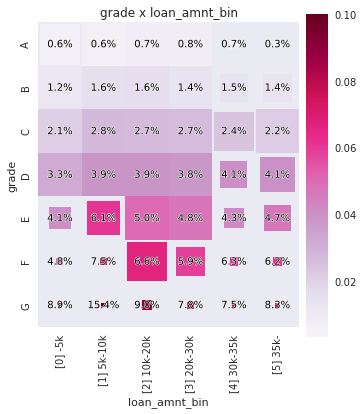

In [4]:
plot("grade", "loan_amnt_bin")

* Grade is a strong feature.
* Grade F, G are not many.
* Loan amount is not a strong feature.

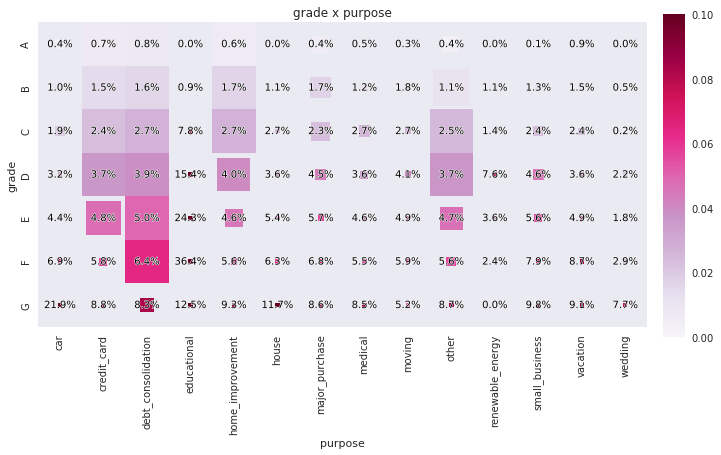

In [5]:
plot("grade", "purpose")

* Grade is a strong feature in almost all purposes.
* Purposes like credit_card and debt_consolidation are many.
* Educational purpose has high probability to be bad status, but not are many.

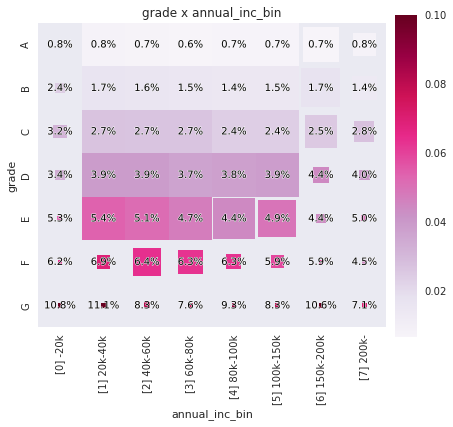

In [6]:
plot("grade", "annual_inc_bin")

* Grade is also a strong feature here.
* Annual income is not strong but effective feature.

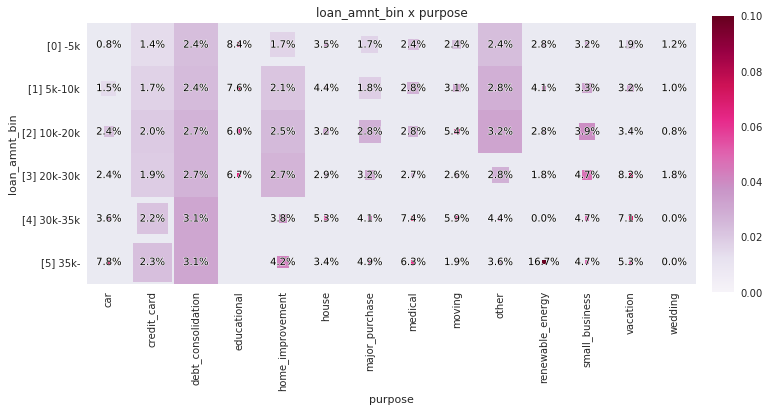

In [7]:
plot("loan_amnt_bin", "purpose")

* Purpose is a strong feature.
* Loan amount is not strong but effective feature depending on purpose.

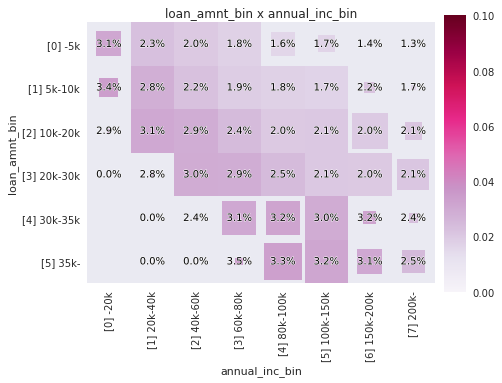

In [8]:
plot("loan_amnt_bin", "annual_inc_bin")

I think this is the most interesting plot in this example.  
* Loan amount and annual income have correlation.
* Balance of loan amount and annual income is a strong feature. They have enough number of samples, so are supposed to be statistically reliable.

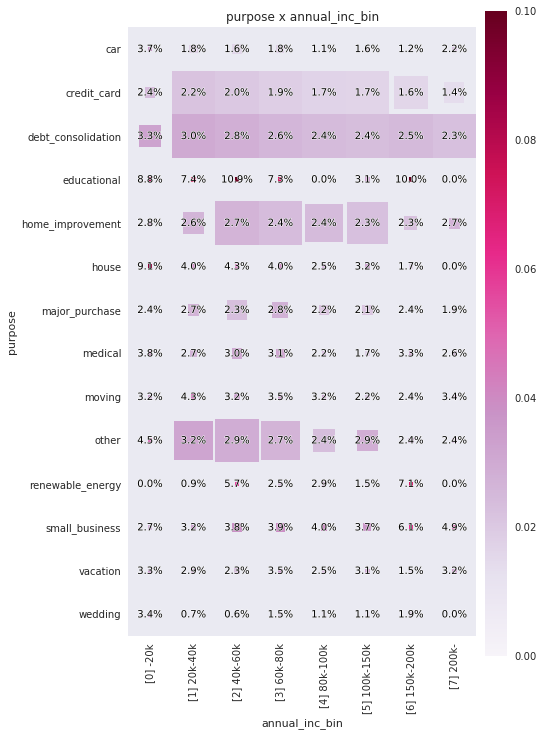

In [9]:
plot("purpose", "annual_inc_bin")

* Annual income is a strong feature. The higher income, the lower probability. However, in small business it goes 
opposite.

### Conclusion
As you can see, it is sometimes beneficial to change cell sizes in heatmap and display one more infomation.  
I hope this is helpful for analyzing data in some competitions.